In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('data/Boston.csv', index_col=0).reset_index(drop=True)
data

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


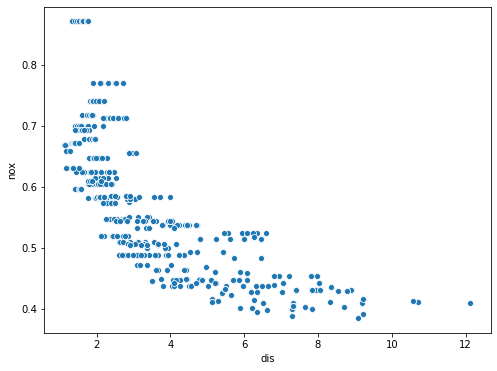

In [3]:
plt.figure(figsize=(8,6))
sb.scatterplot(data=data, x='dis', y='nox');

In [4]:
# Name X, y
X = data['dis'].values.reshape(-1,1)
y = data['nox']

In [5]:
# Write function to choose best degree for poly
def result_poly_mse(X, y):
    mse = pd.Series([])
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    for i in range(1,11):
        X_current = PolynomialFeatures(i).fit_transform(X)
        lm = LinearRegression()
        score = cross_val_score(lm, X_current, y, cv=cv, scoring='neg_mean_squared_error')
        mse.loc[i] = np.mean(np.abs(score))
    return mse

In [6]:
result_poly_mse(X, y)
# See degree = 3 is the best option

1      0.006100
2      0.004437
3      0.004223
4      0.005732
5      0.013495
6      0.105670
7      0.199544
8      1.532568
9      0.639700
10    41.316320
dtype: float64

In [7]:
# Process ANOVA test
X1 = PolynomialFeatures(1).fit_transform(X)
X2 = PolynomialFeatures(2).fit_transform(X)
X3 = PolynomialFeatures(3).fit_transform(X)
X4 = PolynomialFeatures(4).fit_transform(X)
X5 = PolynomialFeatures(5).fit_transform(X)

# Fit multiple models with difference degree
model_1 = sm.GLS(y, X1).fit()
model_2 = sm.GLS(y, X2).fit()
model_3 = sm.GLS(y, X3).fit()
model_4 = sm.GLS(y, X4).fit()
model_5 = sm.GLS(y, X5).fit()

# Perform anova test
anova_test = sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5)
print(anova_test)
# Anova test have same result optimal degree d = 3 compare to crossvalidation method

   df_resid       ssr  df_diff   ss_diff           F        Pr(>F)
0     504.0  2.768563      0.0       NaN         NaN           NaN
1     503.0  2.035262      1.0  0.733301  191.433413  4.006504e-37
2     502.0  1.934107      1.0  0.101155   26.407271  3.966364e-07
3     501.0  1.932981      1.0  0.001125    0.293788  5.880440e-01
4     500.0  1.915290      1.0  0.017691    4.618456  3.210905e-02


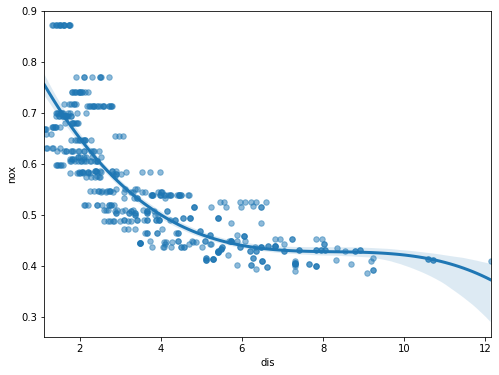

In [8]:
plt.figure(figsize=(8,6))
sb.regplot(x=data['dis'], y=data['nox'], order=3, scatter_kws={"s": 30, 'alpha': 0.5}, line_kws={'linewidth': 3});

In [32]:
# Method 1: manual
def result_spline_cr_mse_manual(X, y):
    mse_mean = pd.Series([])
    for i in range(2,21):
        matrix = dmatrix("cr(x, df={}, constraints='center')".format(i), data={'x': X}, return_type='dataframe')
        cv = KFold(n_splits=10, random_state=None, shuffle=False).split(matrix)
        mse = []
        for train, test in cv:
            lm = sm.GLM(y[train], matrix.iloc[train]).fit()
            lm_pred = lm.predict(matrix.iloc[test])
            mse.append(mean_squared_error(y[test], lm_pred))
        mse_mean.loc[i] = np.mean(mse)
    return mse_mean

In [33]:
# Method 2: Using cross_val_score
def result_spline_cr_mse(X, y):
    mse_mean = pd.Series([])
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    for i in range(2,21):
        matrix  = dmatrix("cr(x, df={}, constraints='center')".format(i), data={'x': X}, return_type='dataframe').iloc[:,1:]
        lm = LinearRegression()            
        score = cross_val_score(lm, matrix, y, cv=cv, scoring='neg_mean_squared_error')
        mse_mean.loc[i] = np.mean(np.abs(score))
    return mse_mean

In [122]:
result_spline_cr_mse(X,y)
# Optimal df is 2

2     0.004182
3     0.004770
4     0.004848
5     0.004910
6     0.005018
7     0.004862
8     0.005013
9     0.004995
10    0.005162
11    0.005208
12    0.005273
13    0.005298
14    0.005308
15    0.005307
16    0.005317
17    0.005362
18    0.005380
19    0.005463
20    0.005465
dtype: float64

In [121]:
# Create function to visualize
def visual_spline(X, y, df):

    matrix = dmatrix("cr(x, df={}, constraints='center')".format(df), data={'x': X}, return_type='dataframe')
    spline_model = sm.GLM(y, matrix).fit()

    # Create y_visual and idx for chart
    y_visual = spline_model.predict(matrix)
    idx = np.argsort(X.flatten())

    # Plot chart
    plt.figure(figsize=(8,6))
    plt.scatter(x=X, y=y, alpha=0.3)
    plt.plot(X[idx], y_visual[idx], color='darkblue', linewidth=3)
    plt.show()

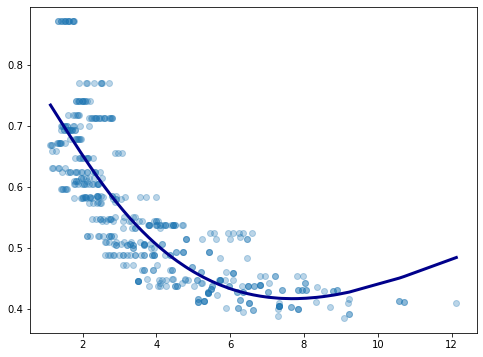

In [120]:
visual_spline(X, y, 2)